<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning

Here we will try to implement transfer learning using a pre trained model, ResNet, in the same fashion as is done in this Kaggle notebook https://www.kaggle.com/code/sheekarbanerjee/brain-tumor-pytorch-resnet50-train-acc-95-3#Data-Loading-and-Augmentation


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/DST/archive.zip" -d "/content/data"

Archive:  /content/drive/MyDrive/DST/archive.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(21

In [5]:
# Data augmentation and normalization for training and normalization for testing

data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Assigning the data directory
data_dir = "/content/data"


#Assinging the training and testing folder of the data with os path-joiner
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}



#defining the image batch size, initiate image data shuffling and num_workers
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}

#finding class names from the training data folder
class_names = image_datasets['Training'].classes


#Initiating condition for device selection whether it will be using GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


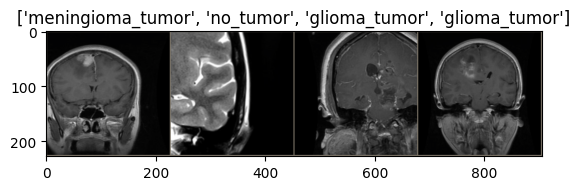

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Getting a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Making a grid from batch
out = torchvision.utils.make_grid(inputs)

#Let's show them with their titles of class names
imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and testing phase
            for phase in ['Training', 'Testing']:
                if phase == 'Training':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Training':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'Testing' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# Setting up the learning rate and momentum
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


In [10]:
print(device)

cuda:0


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training Loss: 0.9443 Acc: 0.6307
Testing Loss: 1.6635 Acc: 0.6675

Epoch 1/49
----------
Training Loss: 0.7031 Acc: 0.7484
Testing Loss: 1.5169 Acc: 0.7487

Epoch 2/49
----------
Training Loss: 0.5902 Acc: 0.7909
Testing Loss: 2.1901 Acc: 0.7107

Epoch 3/49
----------
Training Loss: 0.4697 Acc: 0.8355
Testing Loss: 1.3421 Acc: 0.7259

Epoch 4/49
----------
Training Loss: 0.4329 Acc: 0.8502
Testing Loss: 1.5332 Acc: 0.7030

Epoch 5/49
----------
Training Loss: 0.4165 Acc: 0.8537
Testing Loss: 2.0654 Acc: 0.7284

Epoch 6/49
----------
Training Loss: 0.3325 Acc: 0.8857
Testing Loss: 0.9598 Acc: 0.8426

Epoch 7/49
----------
Training Loss: 0.2381 Acc: 0.9181
Testing Loss: 1.0500 Acc: 0.7741

Epoch 8/49
----------
Training Loss: 0.2057 Acc: 0.9317
Testing Loss: 1.0105 Acc: 0.7766

Epoch 9/49
----------
Training Loss: 0.1885 Acc: 0.9341
Testing Loss: 1.2586 Acc: 0.7665

Epoch 10/49
----------
Training Loss: 0.1891 Acc: 0.9373
Testing Loss: 1.1619 Acc: 0.7766

Epoch 11/49
----------
Training